## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [2]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [6]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

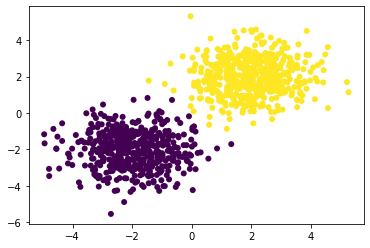

In [7]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [8]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [9]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [10]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

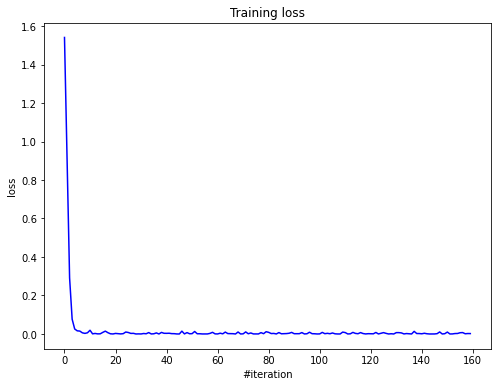

Current loss: 0.002044


In [11]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [13]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [14]:
X_train.shape, y_train.shape

((50000, 28, 28), (50000,))

In [15]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train = np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense()) 
y_val = np.array(enc.transform(y_val.reshape(-1, 1)).todense()) 
y_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()) 

image_size = 28**2
X_train = X_train.reshape(X_train.shape[0], image_size)
X_val = X_val.reshape(X_val.shape[0], image_size)
X_test = X_test.reshape(X_test.shape[0], image_size)

In [16]:
X_train.shape, y_train.shape

((50000, 784), (50000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [65]:
# Your code goes here. ################################################
from sklearn.metrics import accuracy_score
def get_net(in_features, out_features, activation, use_batchnorm=False):
    net = Sequential()
    net.add(Linear(in_features, 256))
    if use_batchnorm:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(256))
    net.add(activation())
    net.add(Linear(256, 128))
    if use_batchnorm:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(128))
    net.add(activation())
    net.add(Linear(128, out_features))
    net.add(LogSoftMax())
    return net

In [91]:
import datetime 


def train(net, optimizer):
    mean_train_epoch = []
    mean_test_epoch = []
    for i in range(n_epoch):
        start = datetime.datetime.now()
        acc_train = []
        acc_test = []
        train_loss = []
        val_loss = []
        for x_batch, y_batch in get_batches((X_train,y_train) , batch_size):

            net.zeroGradParameters()  
            predictions = net.forward(x_batch)
            train_loss.append(criterion.forward(predictions, y_batch))
            y_pred = [np.argmax(pred) for pred in predictions]
            y_batch_test = [np.argmax(batch_i) for batch_i in y_batch]
            acc_train.append(accuracy_score(y_pred, y_batch_test))
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      


        for x_batch, y_batch in get_batches( (X_test, y_test) , batch_size):
            predictions = net.forward(x_batch)
            val_loss.append(criterion.forward(predictions, y_batch))
            y_pred = [np.argmax(pred) for pred in predictions]
            y_batch_test = [np.argmax(batch_i) for batch_i in y_batch]
            acc_test.append(accuracy_score(y_pred, y_batch_test))
        mean_train_epoch.append(np.mean(acc_train))
        mean_test_epoch.append(np.mean(acc_test))
        end = datetime.datetime.now() - start
        print(f'epoch: {i} | train accuracy: {mean_train_epoch[-1]} | test accuracy: {mean_test_epoch[-1]} | time per epoch: {end}')
    return (mean_train_epoch, mean_test_epoch)




## ReLU

In [92]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, ReLU)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_relu, acc_test_relu = train(net, optim)

epoch: 0 | train accuracy: 0.8837675831202046 | test accuracy: 0.9520371835443038 | time per epoch: 0:01:54.720849
epoch: 1 | train accuracy: 0.9614889705882352 | test accuracy: 0.9577729430379747 | time per epoch: 0:01:51.148995
epoch: 2 | train accuracy: 0.9711916560102302 | test accuracy: 0.9634098101265823 | time per epoch: 0:01:48.737830
epoch: 3 | train accuracy: 0.9754275895140664 | test accuracy: 0.9685522151898734 | time per epoch: 0:01:45.793390
epoch: 4 | train accuracy: 0.9806665601023018 | test accuracy: 0.971815664556962 | time per epoch: 0:01:46.446573
epoch: 5 | train accuracy: 0.9837236253196932 | test accuracy: 0.9682555379746836 | time per epoch: 0:01:46.670972
epoch: 6 | train accuracy: 0.9840553069053708 | test accuracy: 0.9722112341772152 | time per epoch: 0:01:50.127192
epoch: 7 | train accuracy: 0.9871603260869566 | test accuracy: 0.977254746835443 | time per epoch: 0:01:52.085077
epoch: 8 | train accuracy: 0.9904971227621484 | test accuracy: 0.9737935126582279 

## ELU

In [94]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, ELU)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_elu, acc_test_elu = train(net, optim)

epoch: 0 | train accuracy: 0.8821771099744244 | test accuracy: 0.9464992088607594 | time per epoch: 0:01:25.960085
epoch: 1 | train accuracy: 0.9592071611253197 | test accuracy: 0.9619264240506329 | time per epoch: 0:01:22.158420
epoch: 2 | train accuracy: 0.9705562659846547 | test accuracy: 0.9652887658227848 | time per epoch: 0:01:22.441866
epoch: 3 | train accuracy: 0.974500479539642 | test accuracy: 0.9714200949367089 | time per epoch: 0:01:23.573364
epoch: 4 | train accuracy: 0.9802389705882353 | test accuracy: 0.9682555379746836 | time per epoch: 0:01:23.157779
epoch: 5 | train accuracy: 0.9830322890025576 | test accuracy: 0.9647943037974683 | time per epoch: 0:01:22.225093
epoch: 6 | train accuracy: 0.9854219948849106 | test accuracy: 0.9729034810126582 | time per epoch: 0:01:22.857946
epoch: 7 | train accuracy: 0.9872522378516624 | test accuracy: 0.9731012658227848 | time per epoch: 0:01:22.524450
epoch: 8 | train accuracy: 0.9881713554987213 | test accuracy: 0.9712223101265823

## LeakyReLU

In [95]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, LeakyReLU)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_relu_l, acc_test_relu_l = train(net, optim)

epoch: 0 | train accuracy: 0.8850303708439897 | test accuracy: 0.9557950949367089 | time per epoch: 0:01:25.252292
epoch: 1 | train accuracy: 0.9620204603580562 | test accuracy: 0.961629746835443 | time per epoch: 0:01:22.875940
epoch: 2 | train accuracy: 0.9704763427109975 | test accuracy: 0.9567840189873418 | time per epoch: 0:01:21.842193
epoch: 3 | train accuracy: 0.9772178708439898 | test accuracy: 0.9720134493670886 | time per epoch: 0:01:22.075059
epoch: 4 | train accuracy: 0.9806825447570332 | test accuracy: 0.9689477848101266 | time per epoch: 0:01:21.059223
epoch: 5 | train accuracy: 0.983491847826087 | test accuracy: 0.9742879746835443 | time per epoch: 0:01:21.492326
epoch: 6 | train accuracy: 0.9835318094629156 | test accuracy: 0.9690466772151899 | time per epoch: 0:01:23.290653
epoch: 7 | train accuracy: 0.9867127557544757 | test accuracy: 0.9743868670886076 | time per epoch: 0:01:23.143569
epoch: 8 | train accuracy: 0.9858815537084399 | test accuracy: 0.9716178797468354 

## SoftPlus

In [ ]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, SoftPlus)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_soft_plus, acc_test_soft_plus = train(net, optim)

## ReLU + BatchNormalization

In [97]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, ReLU, True)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_batchn_relu, acc_test_batchn_relu = train(net, optim)

epoch: 0 | train accuracy: 0.8728260869565216 | test accuracy: 0.9625197784810127 | time per epoch: 0:02:02.803578
epoch: 1 | train accuracy: 0.9658048273657289 | test accuracy: 0.9629153481012658 | time per epoch: 0:01:51.430545
epoch: 2 | train accuracy: 0.9763267263427109 | test accuracy: 0.9722112341772152 | time per epoch: 0:01:52.369499
epoch: 3 | train accuracy: 0.9824648337595908 | test accuracy: 0.9740901898734177 | time per epoch: 0:01:51.745947
epoch: 4 | train accuracy: 0.9855898337595909 | test accuracy: 0.9746835443037974 | time per epoch: 0:01:51.164778
epoch: 5 | train accuracy: 0.9898857097186702 | test accuracy: 0.9756724683544303 | time per epoch: 0:01:51.749000
epoch: 6 | train accuracy: 0.9904052109974425 | test accuracy: 0.9751780063291139 | time per epoch: 0:01:38.581873
epoch: 7 | train accuracy: 0.991775895140665 | test accuracy: 0.9773536392405063 | time per epoch: 0:01:49.825359
epoch: 8 | train accuracy: 0.992335358056266 | test accuracy: 0.9764636075949367 

## ELU + BatchNorm

In [98]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, ELU, True)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_batchn_elu, acc_test_batchn_elu = train(net, optim)

epoch: 0 | train accuracy: 0.8751358695652175 | test accuracy: 0.9622231012658228 | time per epoch: 0:01:23.341997
epoch: 1 | train accuracy: 0.9663083439897698 | test accuracy: 0.9629153481012658 | time per epoch: 0:01:22.992994
epoch: 2 | train accuracy: 0.9770060741687979 | test accuracy: 0.9730023734177216 | time per epoch: 0:01:22.865004
epoch: 3 | train accuracy: 0.982664641943734 | test accuracy: 0.9761669303797469 | time per epoch: 0:01:23.079996
epoch: 4 | train accuracy: 0.9874480498721229 | test accuracy: 0.9730023734177216 | time per epoch: 0:01:25.524646
epoch: 5 | train accuracy: 0.9877917199488491 | test accuracy: 0.9755735759493671 | time per epoch: 0:01:24.483999
epoch: 6 | train accuracy: 0.9902973145780052 | test accuracy: 0.9729034810126582 | time per epoch: 0:01:24.818001
epoch: 7 | train accuracy: 0.9910286125319693 | test accuracy: 0.9785403481012658 | time per epoch: 0:01:24.777002
epoch: 8 | train accuracy: 0.9941656010230179 | test accuracy: 0.9733979430379747

## LeakyReLU + BatchNorm

In [99]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, LeakyReLU, True)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_batchn_l_Relu, acc_test_batchn_l_Relu = train(net, optim)

epoch: 0 | train accuracy: 0.879008152173913 | test accuracy: 0.9603441455696202 | time per epoch: 0:01:49.448559
epoch: 1 | train accuracy: 0.9668038682864449 | test accuracy: 0.9686511075949367 | time per epoch: 0:01:44.287500
epoch: 2 | train accuracy: 0.978332800511509 | test accuracy: 0.9715189873417721 | time per epoch: 0:01:47.649040
epoch: 3 | train accuracy: 0.9824248721227622 | test accuracy: 0.9728045886075949 | time per epoch: 0:01:46.309323
epoch: 4 | train accuracy: 0.9852821291560102 | test accuracy: 0.9713212025316456 | time per epoch: 0:01:45.341623
epoch: 5 | train accuracy: 0.989210358056266 | test accuracy: 0.9759691455696202 | time per epoch: 0:01:49.511856
epoch: 6 | train accuracy: 0.9907488810741688 | test accuracy: 0.9769580696202531 | time per epoch: 0:01:46.226388
epoch: 7 | train accuracy: 0.9935941496163683 | test accuracy: 0.9747824367088608 | time per epoch: 0:01:46.433600
epoch: 8 | train accuracy: 0.9923473465473146 | test accuracy: 0.9780458860759493 |

## SoftPlus + BatchNorm

In [ ]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, SoftPlus, True)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
acc_train_batchn_softplus, acc_test_batchn_softplus = train(net, optim)

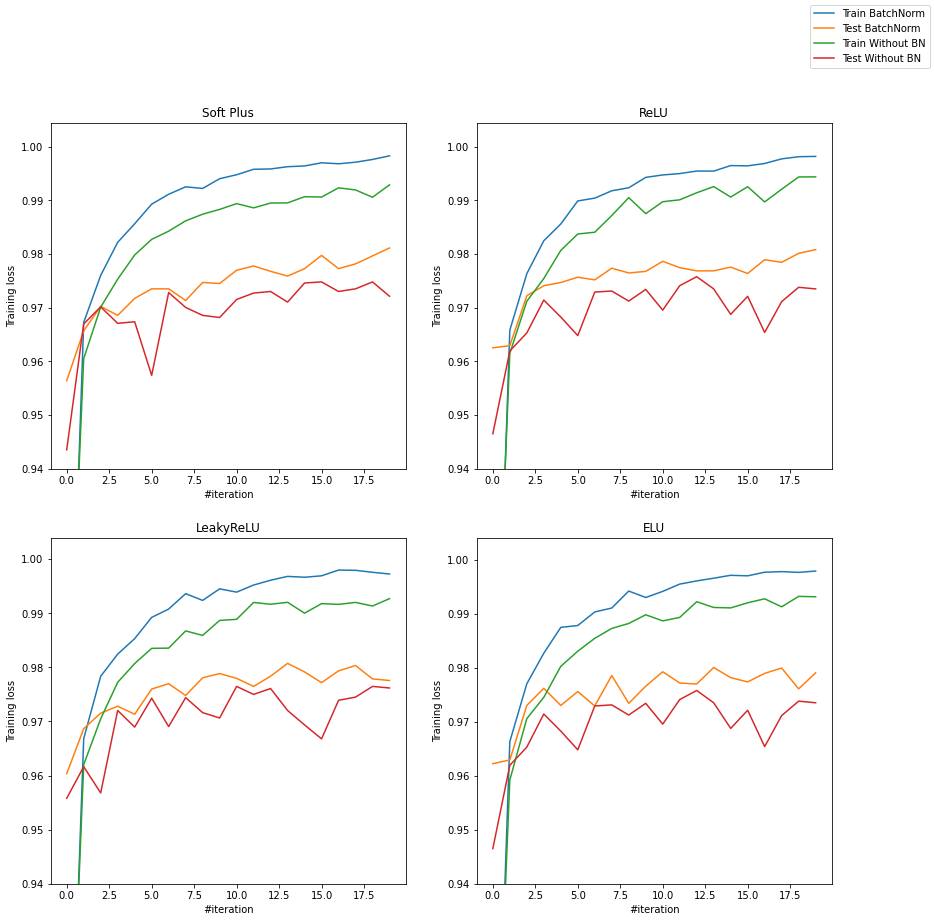

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(14,14))
axs[0, 0].plot(acc_train_batchn_softplus, label='Train BatchNorm')
axs[0, 0].plot(acc_test_batchn_softplus, label='Test BatchNorm')
axs[0, 0].plot(acc_train_soft_plus, label='Train Without BN')
axs[0, 0].plot(acc_test_soft_plus, label='Test Without BN')
axs[0, 0].set_title('Soft Plus')
axs[0, 0].axis(ymin=0.94)

axs[0, 1].plot(acc_train_batchn_relu)
axs[0, 1].plot(acc_test_batchn_relu)
axs[0, 1].plot(acc_train_relu)
axs[0, 1].plot(acc_test_relu)
axs[0, 1].set_title('ReLU')
axs[0, 1].axis(ymin=0.94)

axs[1, 0].plot(acc_train_batchn_l_Relu)
axs[1, 0].plot(acc_test_batchn_l_Relu)
axs[1, 0].plot(acc_train_relu_l)
axs[1, 0].plot(acc_test_relu_l)
axs[1, 0].set_title('LeakyReLU')
axs[1, 0].axis(ymin=0.94)

axs[1, 1].plot(acc_train_batchn_elu)
axs[1, 1].plot(acc_test_batchn_elu)
axs[1, 1].plot(acc_train_elu)
axs[1, 1].plot(acc_test_elu)
axs[1, 1].set_title('ELU')
axs[1, 1].axis(ymin=0.94)

for ax in axs.flat:
    ax.set(xlabel='#iteration', ylabel='Training loss')
fig.legend();

## Adam Oprimizer

In [112]:
batch_size = 128
output_size = 10
n_epoch = 20

net = get_net(image_size, output_size, ReLU, True)
optim = sgd_momentum
optimizer_config = {'learning_rate' : 0.1, 'beta1': 0.97, 'beta2': 0.98, 'epsilon': 1e-2}
optimizer_state = {}
acc_train_batchn_relu_adam, acc_test_batchn_relu_adam = train(net, adam_optimizer)

epoch: 0 | train accuracy: 0.8989570012787724 | test accuracy: 0.954806170886076 | time per epoch: 0:01:40.889953
epoch: 1 | train accuracy: 0.9622002877237851 | test accuracy: 0.965684335443038 | time per epoch: 0:01:36.893044
epoch: 2 | train accuracy: 0.9716512148337595 | test accuracy: 0.9674643987341772 | time per epoch: 0:01:31.512743
epoch: 3 | train accuracy: 0.977181905370844 | test accuracy: 0.9732001582278481 | time per epoch: 0:01:38.449672
epoch: 4 | train accuracy: 0.9790281329923274 | test accuracy: 0.9732990506329114 | time per epoch: 0:01:35.853175
epoch: 5 | train accuracy: 0.9824848145780052 | test accuracy: 0.9701344936708861 | time per epoch: 0:01:32.550537
epoch: 6 | train accuracy: 0.9849384590792838 | test accuracy: 0.9727056962025317 | time per epoch: 0:01:32.340506
epoch: 7 | train accuracy: 0.9870204603580562 | test accuracy: 0.9708267405063291 | time per epoch: 0:01:35.038435
epoch: 8 | train accuracy: 0.9882312979539642 | test accuracy: 0.9728045886075949 |

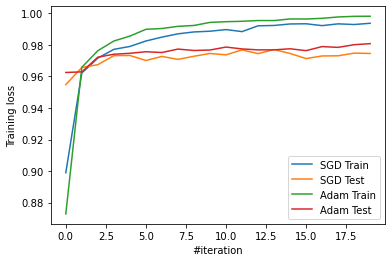

In [114]:
plt.plot(acc_train_batchn_relu, label='SGD Train')
plt.plot(acc_test_batchn_relu, label='SGD Test')
plt.plot(acc_train_batchn_relu_adam, label='Adam Train')
plt.plot(acc_test_batchn_relu_adam, label='Adam Test')
plt.xlabel('#iteration')
plt.ylabel('Training loss')
plt.legend();

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Adam оптимизатор сходится быстрее. Это одно из преимуществ этого оптимизатора, поэтому он так популярен в глубоком обучении. Он сошёлся намного быстрее чем SGD.

Write your personal opinion on the activation functions, think about computation times too. Does BatchNormalization help?

Ответ:

ReLU, ELU и LeakyReLU сходятся похоже и имеют одинаковое качество на отложенной выборке. SoftPlus сходится хуже и дольше, возможно из-за затухания градиентов.

Использование BatchNorm показывает чуть лучшие результаты, но пока нет объяснения почему он работатет лучше.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [116]:
# Your code goes here. ################################################
def get_super_net(in_features, out_features, use_batchnorm=False, p_dropout=0.3):
    net = Sequential()
#     net.add(Linear(in_features, 512))
#     net.add(BatchNormalization())
#     net.add(ChannelwiseScaling(256))
#     net.add(Dropout(p_dropout))
#     net.add(ReLU())
    net.add(Linear(in_features, 128))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(128))
    net.add(Dropout(p_dropout))
    net.add(ReLU())
    net.add(Linear(128, out_features))
    net.add(LogSoftMax())
    return net

batch_size = 128
output_size = 10
n_epoch = 20

net = get_super_net(image_size, output_size)
optim = adam_optimizer
optimizer_config = {'learning_rate' : 0.1, 'beta1': 0.97, 'beta2': 0.98, 'epsilon': 1e-2}
optimizer_state = {}
acc_train_super, acc_test_super = train(net, optim)

epoch: 0 | train accuracy: 0.885465952685422 | test accuracy: 0.9265229430379747 | time per epoch: 0:00:49.239206
epoch: 1 | train accuracy: 0.9363371163682865 | test accuracy: 0.9388844936708861 | time per epoch: 0:00:48.827034
epoch: 2 | train accuracy: 0.9433543797953964 | test accuracy: 0.9443235759493671 | time per epoch: 0:00:55.588191
epoch: 3 | train accuracy: 0.947466432225064 | test accuracy: 0.9448180379746836 | time per epoch: 0:00:47.555163
epoch: 4 | train accuracy: 0.9516224424552431 | test accuracy: 0.9439280063291139 | time per epoch: 0:00:52.040205
epoch: 5 | train accuracy: 0.9549152813299232 | test accuracy: 0.9485759493670886 | time per epoch: 0:00:52.516773
epoch: 6 | train accuracy: 0.9572410485933504 | test accuracy: 0.951443829113924 | time per epoch: 0:00:48.816291
epoch: 7 | train accuracy: 0.9583999360613811 | test accuracy: 0.9509493670886076 | time per epoch: 0:00:50.323294
epoch: 8 | train accuracy: 0.9600743286445014 | test accuracy: 0.9505537974683544 |

Print here your accuracy on test set. It should be around 90%.

In [117]:
# Your answer goes here. ################################################
print(acc_test_super[-1])

0.9566851265822784


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [141]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F


class TorchMNIST(nn.Module):
    def __init__(self, input_size, output_size):
        super(TorchMNIST, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=-1)


In [143]:
def train_torch(train,
               test,
               model,
               criterion,
               optimizer, 
               batch_size=128,
               n_epoch=20):

    loss_history = []
    loss_val_history = []
    
    mean_train_epoch = []
    mean_test_epoch = []

    for i in range(n_epoch):
        start = datetime.datetime.now()
        loss = []
        loss_val = []
        acc_train = []
        acc_test = []
        
        model.train(True)
        for x_batch, y_batch in get_batches(train , batch_size):
            x_batch, y_batch = torch.tensor(x_batch), torch.tensor(y_batch)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            y_pred_batch = [np.argmax(pred) for pred in y_pred.detach().numpy()]
            y_batch_test = [np.argmax(batch_i) for batch_i in y_batch.detach().numpy()]
            acc_train.append(accuracy_score(y_pred_batch, y_batch_test))
            loss_cur = criterion(y_pred, y_batch)
            loss.append(loss_cur.item())
            loss_cur.backward()
            optimizer.step()

            
        loss_history.append(np.mean(loss))

        model.train(False)
        for x_batch, y_batch in get_batches(test , batch_size):
            with torch.no_grad():
                x_batch, y_batch = torch.tensor(x_batch), torch.tensor(y_batch)
                y_pred = model(x_batch)
                loss_cur = criterion(y_pred, y_batch)
                loss_val.append(loss_cur.item())
                y_pred = [np.argmax(pred) for pred in y_pred.detach().numpy()]
                y_batch_test = [np.argmax(batch_i) for batch_i in y_batch.detach().numpy()]
                acc_test.append(accuracy_score(y_pred, y_batch_test))
                
        loss_val_history.append(np.mean(loss_val))
        
        mean_train_epoch.append(np.mean(acc_train))
        mean_test_epoch.append(np.mean(acc_test))
        end = datetime.datetime.now() - start
        print(f'epoch: {i} | train accuracy: {mean_train_epoch[-1]} | test accuracy: {mean_test_epoch[-1]} | time per epoch: {end}')
    return mean_train_epoch, mean_test_epoch


batch_size = 128
output_size = 10
n_epoch = 20

criterion = nn.CrossEntropyLoss()

model = TorchMNIST(image_size, output_size)
optim = torch.optim.Adam(model.parameters(), lr=0.1)

loss_train, loss_val = train_torch(train=(X_train, y_train),
                                  test=(X_test, y_test),
                                  model=model,
                                  criterion=criterion,
                                  optimizer=optim,
                                  batch_size=batch_size,
                                  n_epoch=n_epoch)

epoch: 0 | train accuracy: 0.8689338235294118 | test accuracy: 0.9511471518987342 | time per epoch: 0:00:07.574897
epoch: 1 | train accuracy: 0.9103780370843989 | test accuracy: 0.9579707278481012 | time per epoch: 0:00:07.333467
epoch: 2 | train accuracy: 0.9216072570332481 | test accuracy: 0.9617286392405063 | time per epoch: 0:00:07.120037
epoch: 3 | train accuracy: 0.931957320971867 | test accuracy: 0.9665743670886076 | time per epoch: 0:00:06.798390
epoch: 4 | train accuracy: 0.9325847186700768 | test accuracy: 0.9660799050632911 | time per epoch: 0:00:07.072289
epoch: 5 | train accuracy: 0.9394061700767263 | test accuracy: 0.9654865506329114 | time per epoch: 0:00:07.376709
epoch: 6 | train accuracy: 0.9423873081841432 | test accuracy: 0.9655854430379747 | time per epoch: 0:00:07.159964
epoch: 7 | train accuracy: 0.9422794117647059 | test accuracy: 0.9688488924050633 | time per epoch: 0:00:07.210090
epoch: 8 | train accuracy: 0.9443933823529411 | test accuracy: 0.9685522151898734

Pytorch считает в разы быстрее, над оптимизацией нужно продолжать работать